In [1]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import minimize, curve_fit
from src.MBmodel import cytBindingModel, resids, residsSeq, fitFunc, getConfInterval, getConfIntervalSeq, affFit, affFitSeq

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.779282085969108


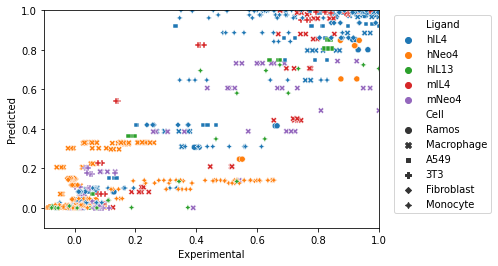

In [6]:
xOpt = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
#plt.savefig("UnConstrainedFit.svg")
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6915023150451409


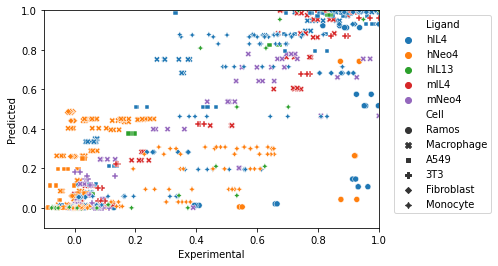

In [9]:
xOpt = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

In [7]:
np.power(np.power(10, xOpt[2::]), -1) * np.power(10, 9)

array([5.18994966e-02, 1.00000000e+05, 1.00000000e+05, 7.68752043e+01,
       1.18546824e+04, 3.43751694e-02, 8.51724187e+04, 1.00000000e+03,
       4.78118364e-01, 1.00000000e+05, 2.77591618e-01, 1.13416240e+03,
       2.33698893e+08])

In [10]:
from scipy.optimize import root, least_squares

def IL4Func(x, KDs, recs, conc):
    print(x, (x*conc)/KDs[0], recs[1]/((KDs[0]*KDs[1])/(x*conc)+1), recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))
    return recs[0] - (x + (x*conc)/KDs[0] + recs[1]/(KDs[0]*KDs[1]/(x*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))

KDs = [1e-7, 10, 5]
recs = [400, 5000, 10000]
conc = 1e-11
x0 = 1000
bnds = ((0, recs[0]))

IL4Ra = least_squares(IL4Func, x0=recs[0], args=(KDs, recs, conc)).x

def SignalingFunc(IL4Ra, KDs, recs, conc, T2W):
    return recs[1]/(KDs[0]*KDs[1]/(IL4Ra*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(IL4Ra*conc)+1) * T2W

print(SignalingFunc(IL4Ra, KDs, recs, conc, 1))
    

[400.] [0.04] [19.92031873] [79.36507937]
[400.00000596] [0.04] [19.92031902] [79.36508054]
[320.31914882] [0.03203191] [15.96481907] [63.65602489]
[320.31915359] [0.03203192] [15.96481931] [63.65602583]
[320.34157854] [0.03203416] [15.9659334] [63.6604539]
[320.34158331] [0.03203416] [15.96593364] [63.66045484]
[79.6263873]


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7668772813023133
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


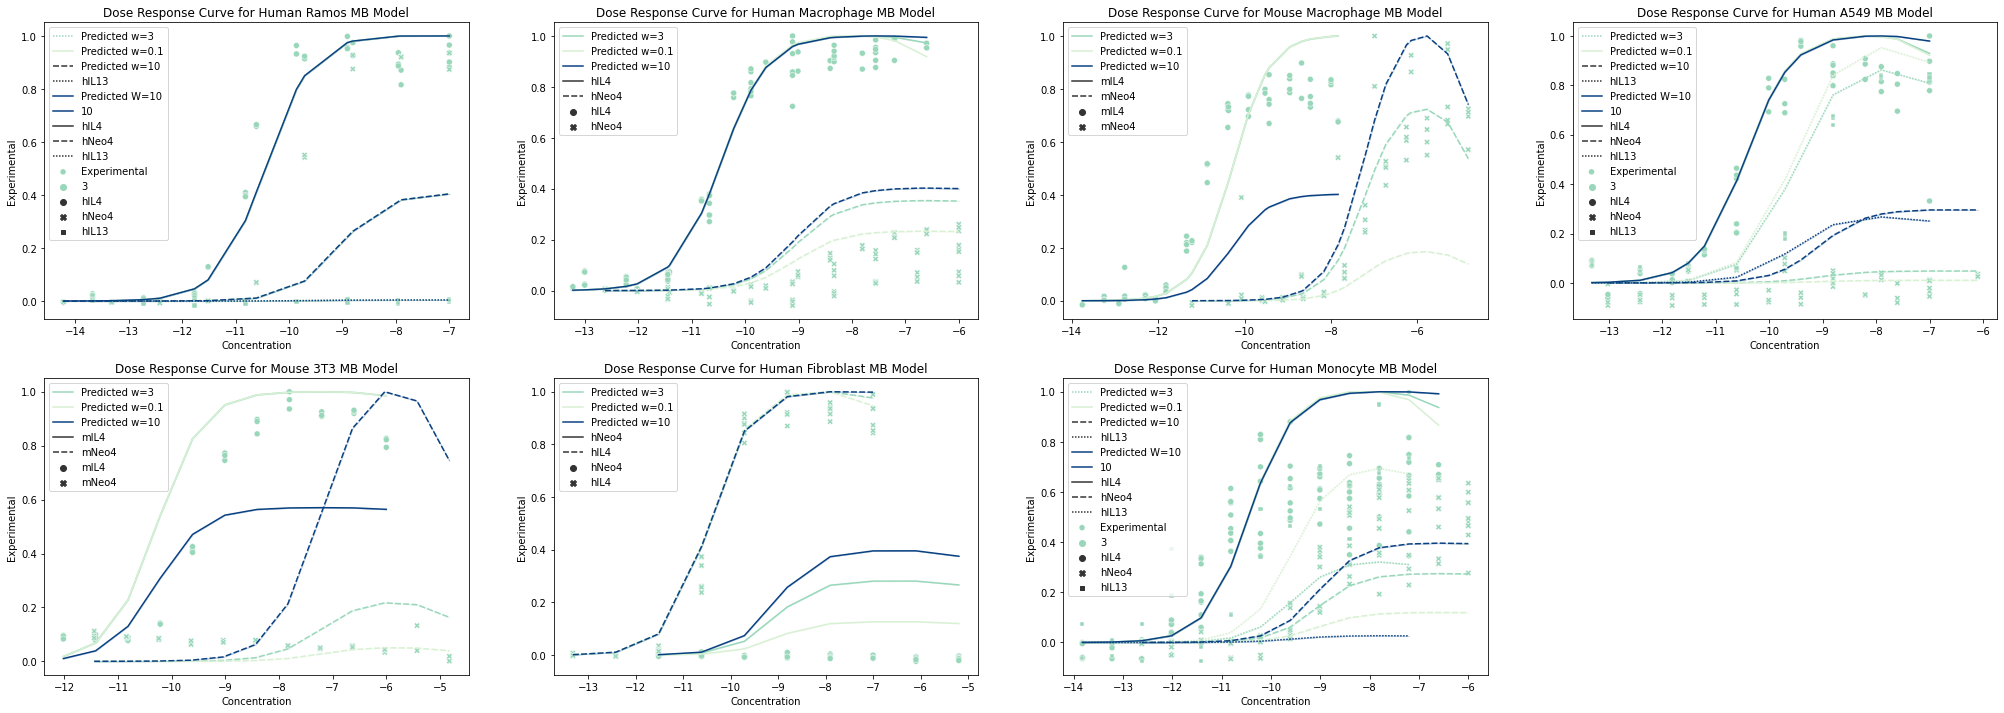

In [11]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values

#Generate range of xOptimals
xOpts = [xOptimal]

weights = [0.1,10]

fig, ax = plt.subplots(2, 4, figsize=(35, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0

for weight in weights:
    xOptimal_new = np.copy(xOptimal)
    xOptimal_new[1] = weight
    xOpts.append(xOptimal_new)

#Generate range of models
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

modelDFs = [modelDF]

for i in range(1,len(xOpts)):
    modelDF_new = resids(xOpts[i], True)
    modelDFs.append(modelDF_new)

i = 0

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        weights = [3,0.1,10]
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", style="Ligand",palette="GnBu", hue=3,hue_norm=(-2,10), ax=ax[i])
        for j, modelDF_ in enumerate(modelDFs):
            isoData_ = modelDF_.loc[(modelDF_.Cell == cell) & (modelDF_.Animal == animal)]
            sns.lineplot(data=isoData_, x="Concentration", y="Predicted", label="Predicted W="+str(weights[j]), style="Ligand", palette="GnBu", hue=weights[j], hue_norm=(-2,10), ax=ax[i])
        ax[i].set_title("Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax[i].get_legend_handles_labels()
        #print(handles)
        #print(labels)
        ax[i].legend([handles[2]] + [handles[7]] + [handles[12]]+ handles[13:15] + handles[17::], ["Predicted w=3"] + ["Predicted w=0.1"] + ["Predicted w=10"] + labels[13:15] + labels[17::])
        i += 1

plt.savefig("MBParametric.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6915023150451409
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


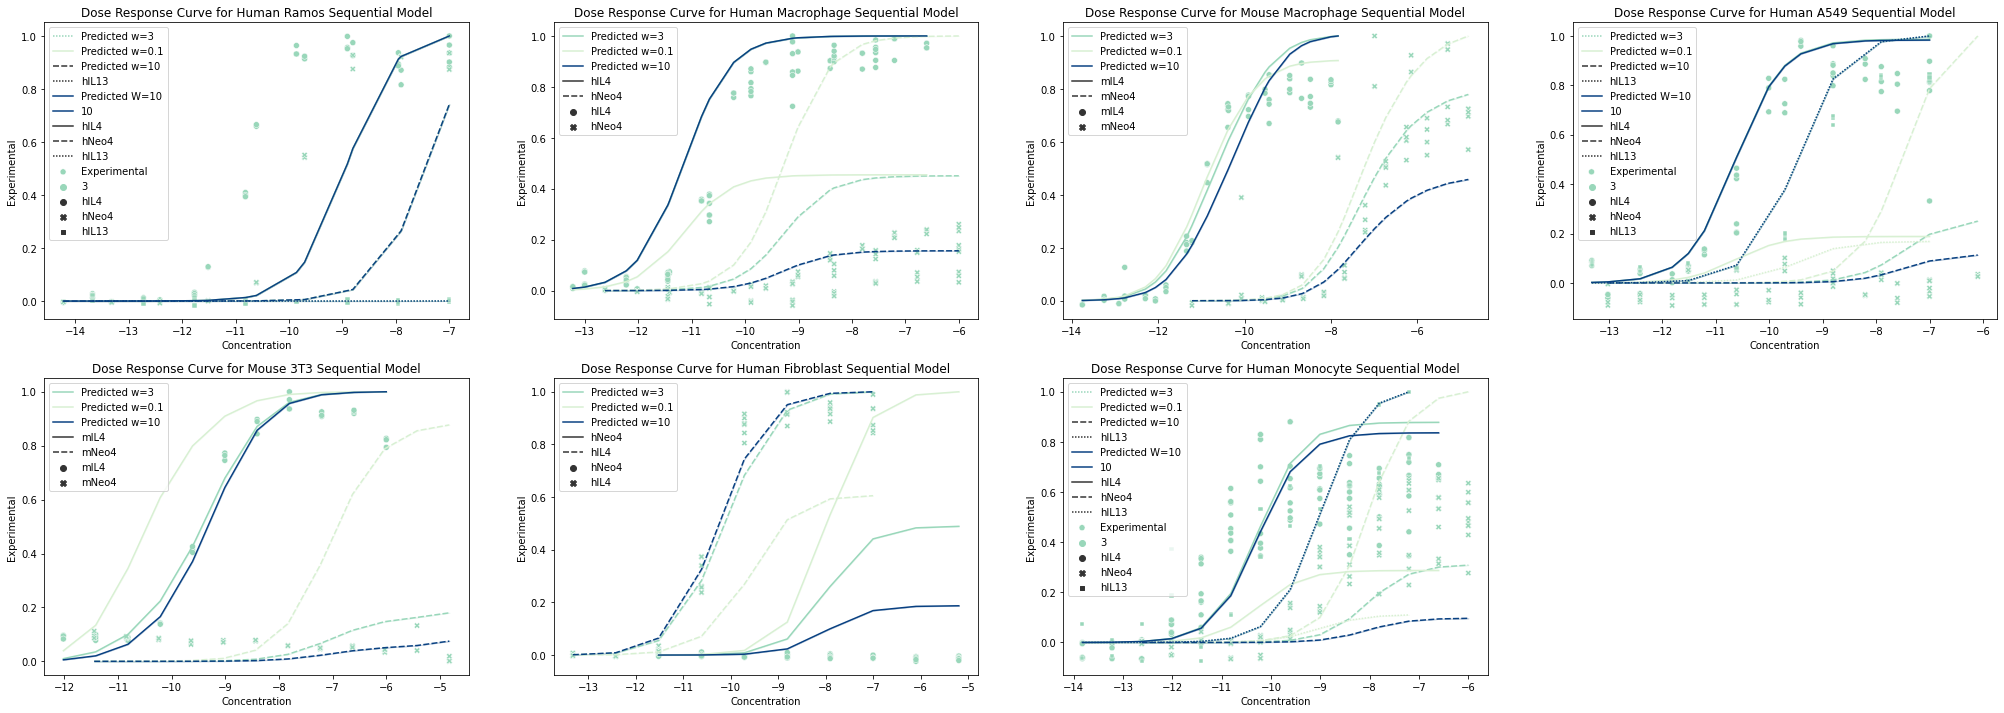

In [9]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values

#Generate range of xOptimals
xOpts = [xOptimal]

weights = [0.1,10]

fig, ax = plt.subplots(2, 4, figsize=(35, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0

for weight in weights:
    xOptimal_new = np.copy(xOptimal)
    xOptimal_new[0] = weight
    xOpts.append(xOptimal_new)

#Generate range of models
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

modelDFs = [modelDF]

for i in range(1,len(xOpts)):
    modelDF_new = residsSeq(xOpts[i], True)
    modelDFs.append(modelDF_new)

i = 0

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        weights = [3,0.1,10]
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", style="Ligand",palette="GnBu", hue=3,hue_norm=(-2,10), ax=ax[i])
        for j, modelDF_ in enumerate(modelDFs):
            isoData_ = modelDF_.loc[(modelDF_.Cell == cell) & (modelDF_.Animal == animal)]
            sns.lineplot(data=isoData_, x="Concentration", y="Predicted", label="Predicted W="+str(weights[j]), style="Ligand", palette="GnBu", hue=weights[j], hue_norm=(-2,10), ax=ax[i])
        ax[i].set_title("Dose Response Curve for " + animal + " " + cell + " Sequential Model")
        handles, labels = ax[i].get_legend_handles_labels()
        #print(handles)
        #print(labels)
        ax[i].legend([handles[2]] + [handles[7]] + [handles[12]]+ handles[13:15] + handles[17::], ["Predicted w=3"] + ["Predicted w=0.1"] + ["Predicted w=10"] + labels[13:15] + labels[17::])
        i += 1

plt.savefig("SeqParametric.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7668772813023133


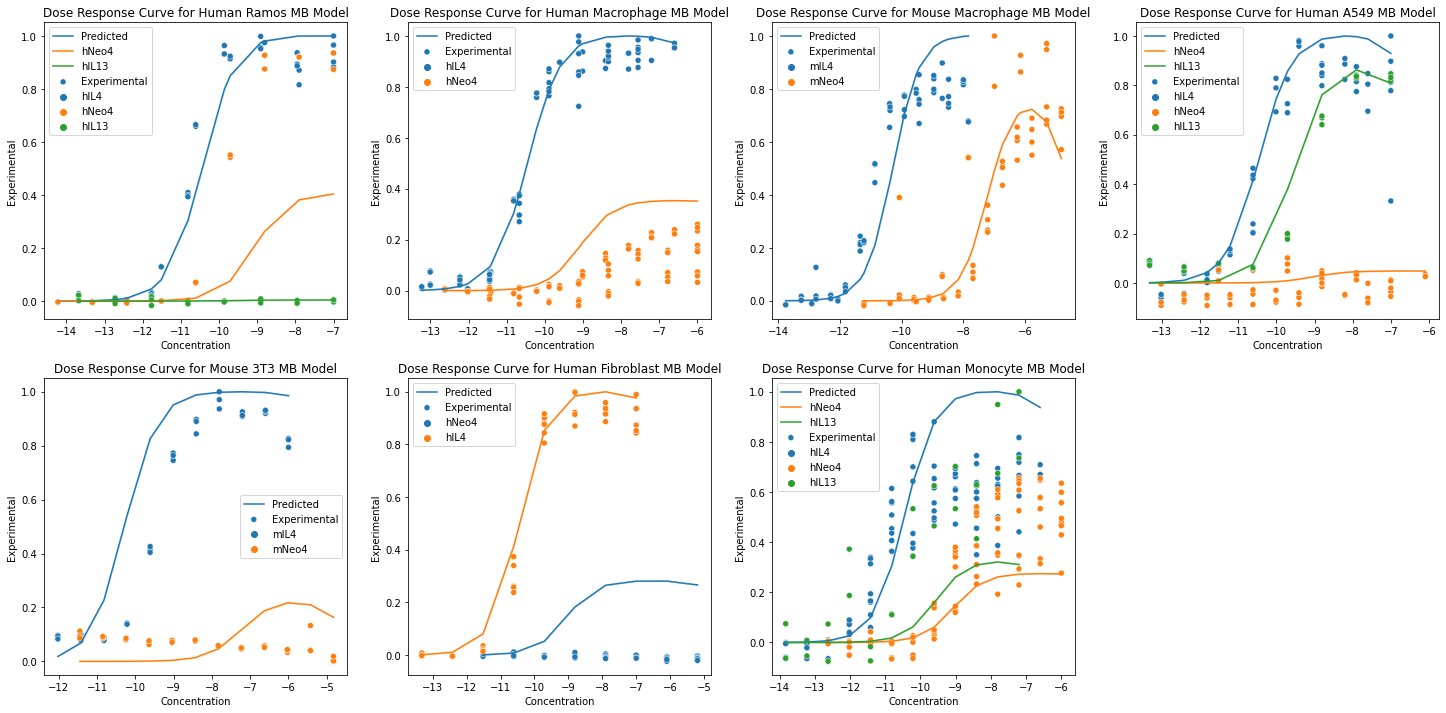

In [2]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i])
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        i += 1

plt.savefig("MBDoseResponse.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6915023150451409


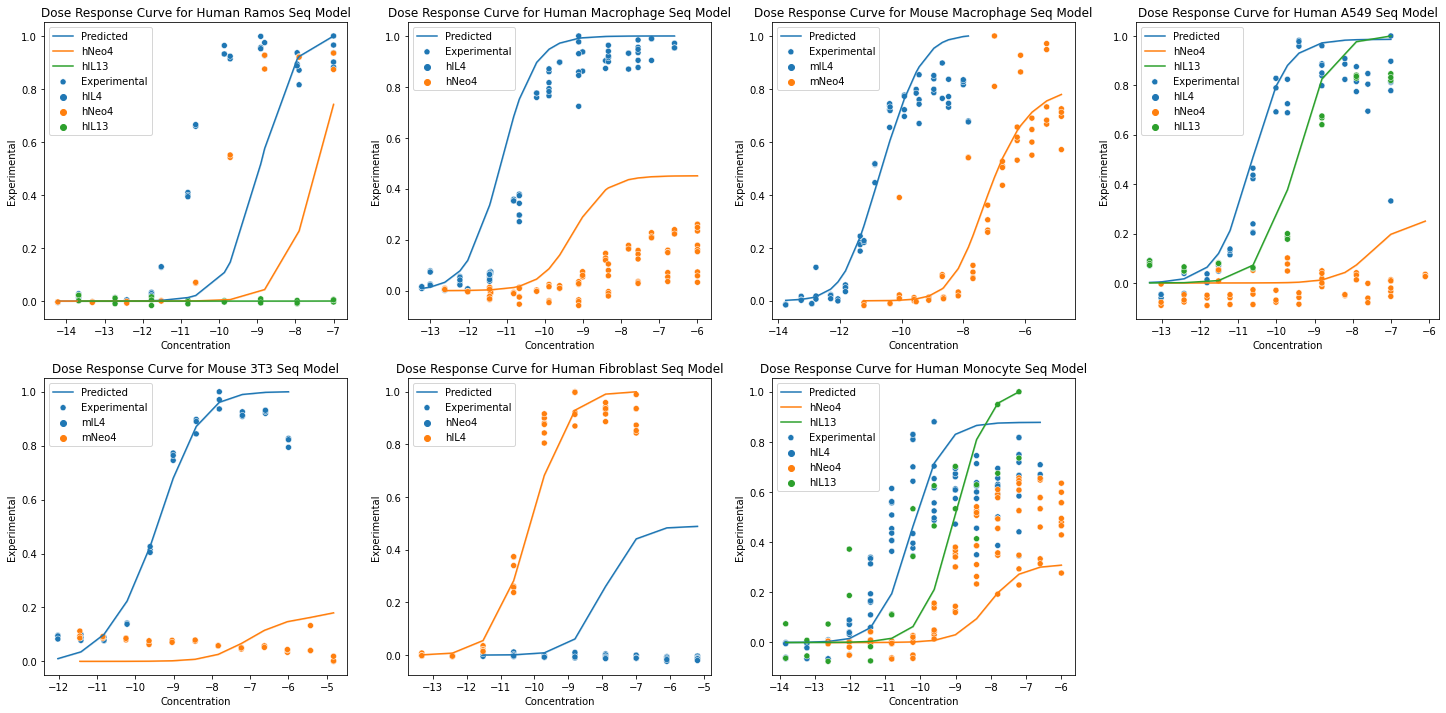

In [27]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0

for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i])
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " Seq Model")
        handles, labels = ax[i].get_legend_handles_labels()
        ax[i].legend([handles[0]] + handles[4::], [labels[0]] + labels[4::])
        i += 1

plt.savefig("SeqDoseResponse.svg")

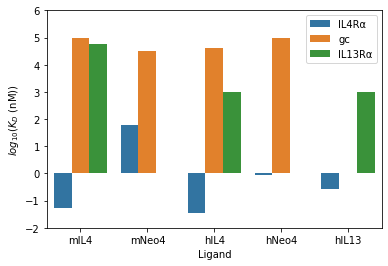

In [2]:
affFit()
plt.savefig("MBAffs.svg")

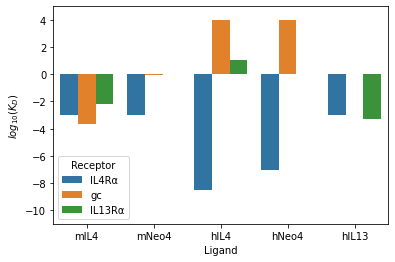

In [3]:
affFitSeq()
plt.savefig("SeqAffs.svg")

In [5]:
getConfInterval()

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
[-14.           0.5         10.28466421   4.           4.22932341
   7.21804679   4.49180295  10.45448344   4.39041829   6.
   9.06526939   4.           9.57786308   6.           1.89931766]
5.278391786097841
[-13.9999999    0.5         10.28466421   4.           4.22932341
   7.21804679   4.49180295  10.45448344   4.39041829   6.
   9.06526939   4.           9.57786308   6.           1.89931766]
5.278391786135703
[-14.           0.50000001  10.28466421   4.           4.22932341
   7.21804679   4.49180295  10.45448344   4.39041829   6.
   9.06526939   4.           9.57786308   6.           1.89931766]
5.2783917907

array([8.78214479e+00, 1.17355687e-01, 4.55601833e-03, 3.49414186e-02,
       9.84930711e-02, 9.89617354e-03, 1.71631878e-02, 2.83082070e-03,
       9.81930310e-02, 2.14746330e-02, 1.06758054e-02, 9.87866055e-02,
       1.23655517e-02, 2.25881551e-02, 3.16023210e+02])

In [6]:
getConfIntervalSeq()

[ 3.         -3.         -3.64104086 -2.17708416 -3.         -0.08471181
 -8.49649983  4.          1.07431888 -7.01398656  4.         -3.
 -3.27499266 -1.        ]
6.072049073891993
[ 3.00000004 -3.         -3.64104086 -2.17708416 -3.         -0.08471181
 -8.49649983  4.          1.07431888 -7.01398656  4.         -3.
 -3.27499266 -1.        ]
6.07204905762905
[ 3.         -3.00000004 -3.64104086 -2.17708416 -3.         -0.08471181
 -8.49649983  4.          1.07431888 -7.01398656  4.         -3.
 -3.27499266 -1.        ]
6.072049073891996
[ 3.         -3.         -3.64104092 -2.17708416 -3.         -0.08471181
 -8.49649983  4.          1.07431888 -7.01398656  4.         -3.
 -3.27499266 -1.        ]
6.072049073891994
[ 3.         -3.         -3.64104086 -2.17708419 -3.         -0.08471181
 -8.49649983  4.          1.07431888 -7.01398656  4.         -3.
 -3.27499266 -1.        ]
6.072049073891993
[ 3.         -3.         -3.64104086 -2.17708416 -3.00000004 -0.08471181
 -8.49649983  4.  

array([2.58401258e-02, 1.13658384e+04, 1.13658407e+04, 1.13658519e+04,
       2.06450968e-01, 2.03642475e-01, 2.22464187e-02, 2.70323236e-02,
       2.25400507e-02, 3.49221451e-02, 3.58767587e-02, 1.13054976e+01,
       1.13055577e+01, 6.26706433e+02])